[*********************100%***********************]  3 of 3 completed


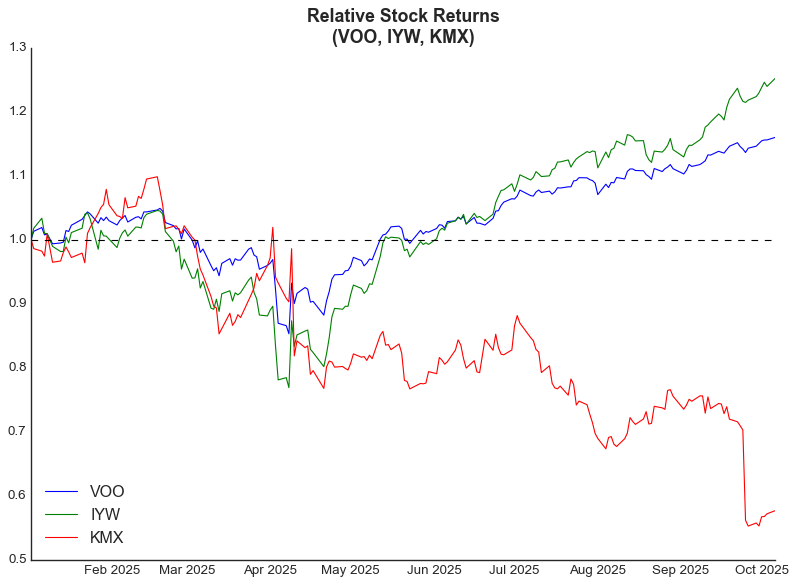

VOO: 0.0119
IYW: 0.0169
KMX: 0.0247


In [110]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import numpy as np

tickers = [
    "VOO"
    , "IYW"
    , "KMX"
]

# Start date
start = "2025-01-01"

# End date (today)
end = datetime.today().strftime('%Y-%m-%d')

# Download data
df = yf.download(tickers, start=start, end=end)

# Extract dates from index
dates = df.index

# Initialize dictionary for normalized prices
di = {'dates': dates}

# Normalize each ticker's price (relative to the first value)
for ticker in tickers:
    data = df['Close'][ticker].tolist()  # Extract close prices
    first_el = data[0]  # First price for normalization
    lst = [price / first_el for price in data]  # Compute normalized prices
    di[ticker] = lst  # Store in dictionary

# Convert to DataFrame and set index
df = pd.DataFrame(data=di).set_index('dates')

# Make the plot:
fig, ax = plt.subplots(figsize=(12,8))
plt.style.use('seaborn-v0_8-white')

for col in df.columns.tolist():
    ax.plot(df.index, df[col], label=col)
    # ax.scatter(df.index[::-1][0], df[col][::-1][0], s=24)
    # ax.axhline(df[col][::-1][0], color='black', linestyle='--')

ax.axhline(1, color='black', linestyle='--', linewidth=1)
ax.set_title(f'Relative Stock Returns\n({', '.join(tickers)})', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc = 'lower left')
plt.savefig('/Users/joepellegrino/stocks_trend.png')
plt.show()

# Calculate implied volatilities:
volatilities = dict()

for ticker in tickers:
    results = []
    results = [di[ticker][i] - di[ticker][i-1] for i in range(1,len(di[ticker]))]
    std_dev_of_daily_returns = np.std(results)
    volatilities[ticker] = std_dev_of_daily_returns

for key in volatilities:
    print(f"{key}: {round(volatilities[key], 4)}")

[*********************100%***********************]  1 of 1 completed

1995 6.7%
1996 5.4%
1997 4.4%
1998 4.6%
1999 4.2%
2000 5.0%
2001 6.6%
2002 9.8%
2003 7.7%
2004 8.9%
2005 9.8%
2006 10.6%
2007 8.7%
2008 13.9%
2009 13.8%


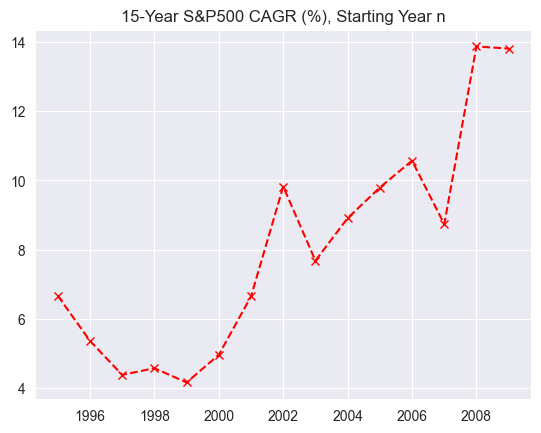

In [84]:
# Yearly Return:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np

tickers = [
    "SPY"
]

start = "1995-01-01"
end = "2024-12-31"

# Download data
df = yf.download(tickers, start=start, end=end)

# Extract dates from index
dates = df.index

# Initialize dictionary for normalized prices
di = {'dates': dates}

# Normalize each ticker's price (relative to the first value)
for ticker in tickers:
    data = df['Close'][ticker].tolist()  # Extract close prices
    first_el = data[0]  # First price for normalization
    lst = [price / first_el for price in data]  # Compute normalized prices
    di[ticker] = lst  # Store in dictionary

# Convert to DataFrame and set index
df = pd.DataFrame(data=di).set_index('dates')

conn = sqlite3.connect("test.db")

dates = df[tickers[0]].index.tolist()
prices = df[tickers[0]].tolist()

df = pd.DataFrame(data={
    "date": dates,
    "price": prices
})

df.to_sql('gasoline', conn, if_exists='replace', index=False)

# Query from the table using SQLite
query = """
with

a as (SELECT
strftime('%Y', date) year
, strftime('%m', date) month
, strftime('%d', date) day
, date
, price
FROM gasoline
)

, b as (select
*
, row_number() over (partition by year order by month desc, day desc) rn
from a
)

select
*
from b
where rn = 1
order by year, month, day
;
"""
result = pd.read_sql(query, conn)

def calc_avg_growth(start_year, end_year):
    start_price = result.query(f"year == '{start_year}'")["price"].tolist()[0]
    end_price = result.query(f"year == '{end_year}'")["price"].tolist()[0]
    final_result1 = (end_price / start_price) ** (1 / (end_year - start_year)) - 1
    return final_result1

years = []
returns_15y = []

for i in range(1995,2010):
    res = calc_avg_growth(i, i+15)
    print(i, f"{round(100*res,1)}%")
    years.append(i)
    returns_15y.append(res * 100)

plt.plot(years, returns_15y, linestyle="--", color="red", marker="x")
plt.grid(True)
plt.title("15-Year S&P500 CAGR (%), Starting Year n")
plt.show()

In [21]:
# Simulate dollar-cost averaging:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

# import tkinter as tk
# from tkinter import simpledialog

# root = tk.Tk()
# root.withdraw()  # Hide the root window
# tickers_input = simpledialog.askstring("Input", "Enter tickers:")
# tickers = tickers_input.split(" ")
# start = simpledialog.askstring("Input", "Enter a start date:")

tickers = [
    "IVV" # S&P 500
]

# Start date
start = "2025-01-01"

# End date (today)
end = datetime.today().strftime('%Y-%m-%d')

# Download data
df = yf.download(tickers, start=start, end=end)

# Extract dates from index
dates = df.index

daily_prices = df["Close"].IVV.tolist()

first_close = daily_prices[0] 
last_close = daily_prices[::-1][0]
avg_price = np.mean(daily_prices)
max_price = max(daily_prices)

dca_return = (last_close - avg_price) / avg_price
ytd_return = (last_close - first_close) / first_close
max_return = (last_close - max_price) / max_price

print(f"DCA Return Since Start: {round(float(dca_return), 3)}")
print(f"Return Since Start: {round(float(ytd_return), 3)}")
print(f"Deviation from Maximum: {round(float(max_return), 3)}")
print(f"Current Price: {round(float(last_close),2)}")

[*********************100%***********************]  1 of 1 completed

DCA Return Since Start: -0.06
Return Since Start: -0.044
Deviation from Maximum: -0.088
Current Price: 561.48


In [3]:
# Crash dates:

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

# Download stock data

ticker = "DIS"
threshold = 0.50

tickers = [ticker]  # S&P 500
start = "2017-01-01"
end = datetime.today().strftime('%Y-%m-%d')

df = yf.download(tickers, start=start, end=end)["Close"]

# Extract relevant series
df_ivv = df[ticker]

# Vectorized calculation for drawdowns
rolling_max = df_ivv.cummax()  # Tracks the highest price up to each date
drawdown = df_ivv / rolling_max - 1  # Calculate drawdown percentage

# Find dates where the drawdown exceeds the threshold
crash_dates = drawdown[drawdown <= -threshold]

# Print results
pd.DataFrame(data=drawdown)

[*********************100%***********************]  1 of 1 completed


,DIS
Date,
2017-01-03,0.000000
2017-01-04,0.000000
2017-01-05,-0.000559
2017-01-06,0.000000
2017-01-09,-0.005689
...,...
2025-05-14,-0.433732
2025-05-15,-0.437342
2025-05-16,-0.431325


In [51]:
# Biggest Declines

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Define the stock ticker
ticker = "SPY"  # Replace with your desired stock symbol
num_days = 20000

# Fetch historical market data
data = yf.Ticker(ticker).history(period=f"{num_days}d")

# Extract the closing price
closing_price = data['Close']

# closing_price

dtd_change = []

for i in range(len(closing_price.tolist())):
    if i == 0:
        val = 1
    else:
        val = closing_price.tolist()[i] / closing_price.tolist()[i-1]
    dtd_change.append(val - 1)

dates = closing_price.index
price = closing_price.tolist()
change = dtd_change

df_new = pd.DataFrame(
    data = {
        "date": dates,
        "price": price,
        "change": change
    }
)

df_new2 = df_new[["date", "change"]].sort_values(by="change")

conn = sqlite3.connect("test.db")
df_new2.to_sql("table1", conn, if_exists="replace")

pd.read_sql_query("""
with

a as (select
*
, strftime('%Y', date) AS year
, row_number() over (order by abs(change) desc) rn
from table1
)

, b as (select
*
from a
where abs(change) >= 0.05
)

select
year
, count(*) num
from b
group by 1
order by 2 desc
;
"""

, conn
)

,year,num
0,2008,16
1,2020,11
2,2009,3
3,1998,3
4,2025,2
5,2000,2
6,1997,2
7,2022,1
8,2018,1
9,2011,1


In [50]:
# Was Apr to Jun 2025 the largest 60-day increase?

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

tickers = [
    "IVV" # S&P 500
]

# Start date
start = "2010-01-01"

# End date (today)
end = datetime.today().strftime('%Y-%m-%d')

# Download data
df = yf.download(tickers, start=start, end=end)

df1 = df["Close"]["IVV"].to_frame()

dates = df1.index
ivv = df1["IVV"].values

df2 = pd.DataFrame(
    data = {
        "date": dates,
        "IVV": ivv
    }
)

df2["IVV_lag42"] = df2["IVV"].shift(42)

df2 = df2.dropna()

df2["inc"] = df2["IVV"] / df2["IVV_lag42"] - 1

df3 = df2.sort_values("inc").reset_index()

df3.to_csv("/Users/joepellegrino/changes.csv")

df3 = df3.set_index("date")

df3.head()

[*********************100%***********************]  1 of 1 completed


,index,IVV,IVV_lag42,inc
date,,,,
2020-03-23,2571,205.908035,305.081146,-0.325071
2020-03-20,2570,211.874893,305.017029,-0.305367
2020-03-18,2568,221.049805,304.668701,-0.274458
2020-03-19,2569,221.865585,305.677002,-0.274183
2020-03-16,2566,220.087418,301.479065,-0.269974


In [48]:
# Number of consecutive rising days: ***

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

pd.set_option('display.max_rows', None)

tickers = [
    "SPY" # S&P 500   
]

# Start date
start = "2020-01-01"

# End date (today)
end = datetime.today().strftime('%Y-%m-%d')

# Download data
df = yf.download(tickers, start=start, end=end)

# Extract dates from index
dates = df.index

df = df['Close']

vals = df['SPY'].tolist()
dates = df.index.tolist()

conn = sqlite3.connect('test.db')

df1 = pd.DataFrame(data = {
    "date": dates,
    "SPY": vals
})

df1["SPY_L1"] = df1["SPY"].shift(1)

df1 = df1.dropna()

spy = df1["SPY"].tolist()
spy1 = df1["SPY_L1"].tolist()
comp = [0 for i in range(len(spy))]

for i in range(len(spy)):
    if i > 0:
        if spy[i] >= spy1[i]:
            comp[i] = comp[i-1] + 1
        else:
            comp[i] = 0
    if i == 0:
        if spy[i] >= spy1[i]:
            comp[i] = 1
        else:
            comp[i] = 0

df1["comp"] = comp

# df1.sort_values(by='date', ascending=False)

df1.query("comp >= 8").sort_values(by="date", ascending=False)

[*********************100%***********************]  1 of 1 completed


,date,SPY,SPY_L1,comp
1340,2025-05-02,563.527100,555.284363,9
1339,2025-05-01,555.284363,551.376831,8
1164,2024-08-19,551.197510,545.977234,8
1099,2024-05-15,520.137939,513.775879,10
1098,2024-05-14,513.775879,511.429413,9
1097,2024-05-13,511.429413,511.360748,8
970,2023-11-08,426.234222,425.922211,8
467,2021-11-08,443.323181,442.944977,8
